In [1]:
# executing this cell will install all required julia packages
import Pkg
Pkg.activate(".")
Pkg.instantiate()

 Activating environment at `~/Documents/Harvard/Natesh/TemperatureImputations/notebooks/Project.toml`


In [2]:
# using TimeSeries
using DataFrames
using CSV
using Proj4
import PyPlot; plt=PyPlot
using Dates: Hour, DateTime, Date, Day
using Statistics: mean, var, quantile
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(8,5))
plt.rc("savefig", dpi=400.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
data_dir = abspath(joinpath(@__DIR__, "..", "data"))
# include(joinpath(data_dir, "src/preprocessing.jl"))
# include(joinpath(data_dir, "src/utils.jl"))
;

In [3]:
using Revise
import TemperatureImputations

┌ Info: Precompiling TemperatureImputations [3ecd16f4-a557-4f5c-bed7-042ea12fe1be]
└ @ Base loading.jl:1278
┌ Warning: Package TemperatureImputations does not have Statistics in its dependencies:
│ - If you have TemperatureImputations checked out for development and have
│   added Statistics as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with TemperatureImputations
└ Loading Statistics into TemperatureImputations from project dependency, future warnings for TemperatureImputations are suppressed.


In [4]:
isdList = TemperatureImputations.read_isdList(; data_dir=data_dir)
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[!,:USAF]],:]
hourly_cat= TemperatureImputations.read_Stations(isdSubset; data_dir=data_dir)
TnTx_dict = Dict{Int, Dict{Hour, DataFrame}}()
for istation in 1:4
    TnTx_dict[istation] = Dict{Hour,DataFrame}()
    for hr in Hour(0):Hour(1):Hour(24)
        TnTx = TemperatureImputations.test_data(hourly_cat, istation, hr)
        TnTx_dict[istation][hr] = TnTx
    end
end
        
waterloo = hourly_cat[hourly_cat[!,:station].==3,:]
waterloo_TnTx_dict = TnTx_dict[3]
;

In [5]:
iowa_time(ts) = ts - Hour(6)
iowa_time(waterloo[1,:ts])

2014-12-31T18:00:00

In [6]:
begin
    hr = Hour(23)
    low = Hour(8)
    peak = Hour(20)
    TnTx_low = waterloo_TnTx_dict[low]
    TnTx_peak = waterloo_TnTx_dict[peak]
    
    apr3_low = TnTx_low[TnTx_low[!,:ts_day] .== DateTime(2015,4,4),:]
    apr3_peak = TnTx_peak[TnTx_peak[!,:ts_day] .== DateTime(2015,4,4),:]
    
    global apr3_realmax = apr3_low[1,:Tx]
    global apr3_measured = apr3_peak[1,:Tx]
    @show apr3_realmax
    @show apr3_measured
    apr3_txtime = iowa_time(apr3_low[1, :Tx_time])
    @show apr3_txtime
end

apr3_realmax = 7.2
apr3_measured = 15.6
apr3_txtime = DateTime("2015-04-03T14:54:00")


2015-04-03T14:54:00

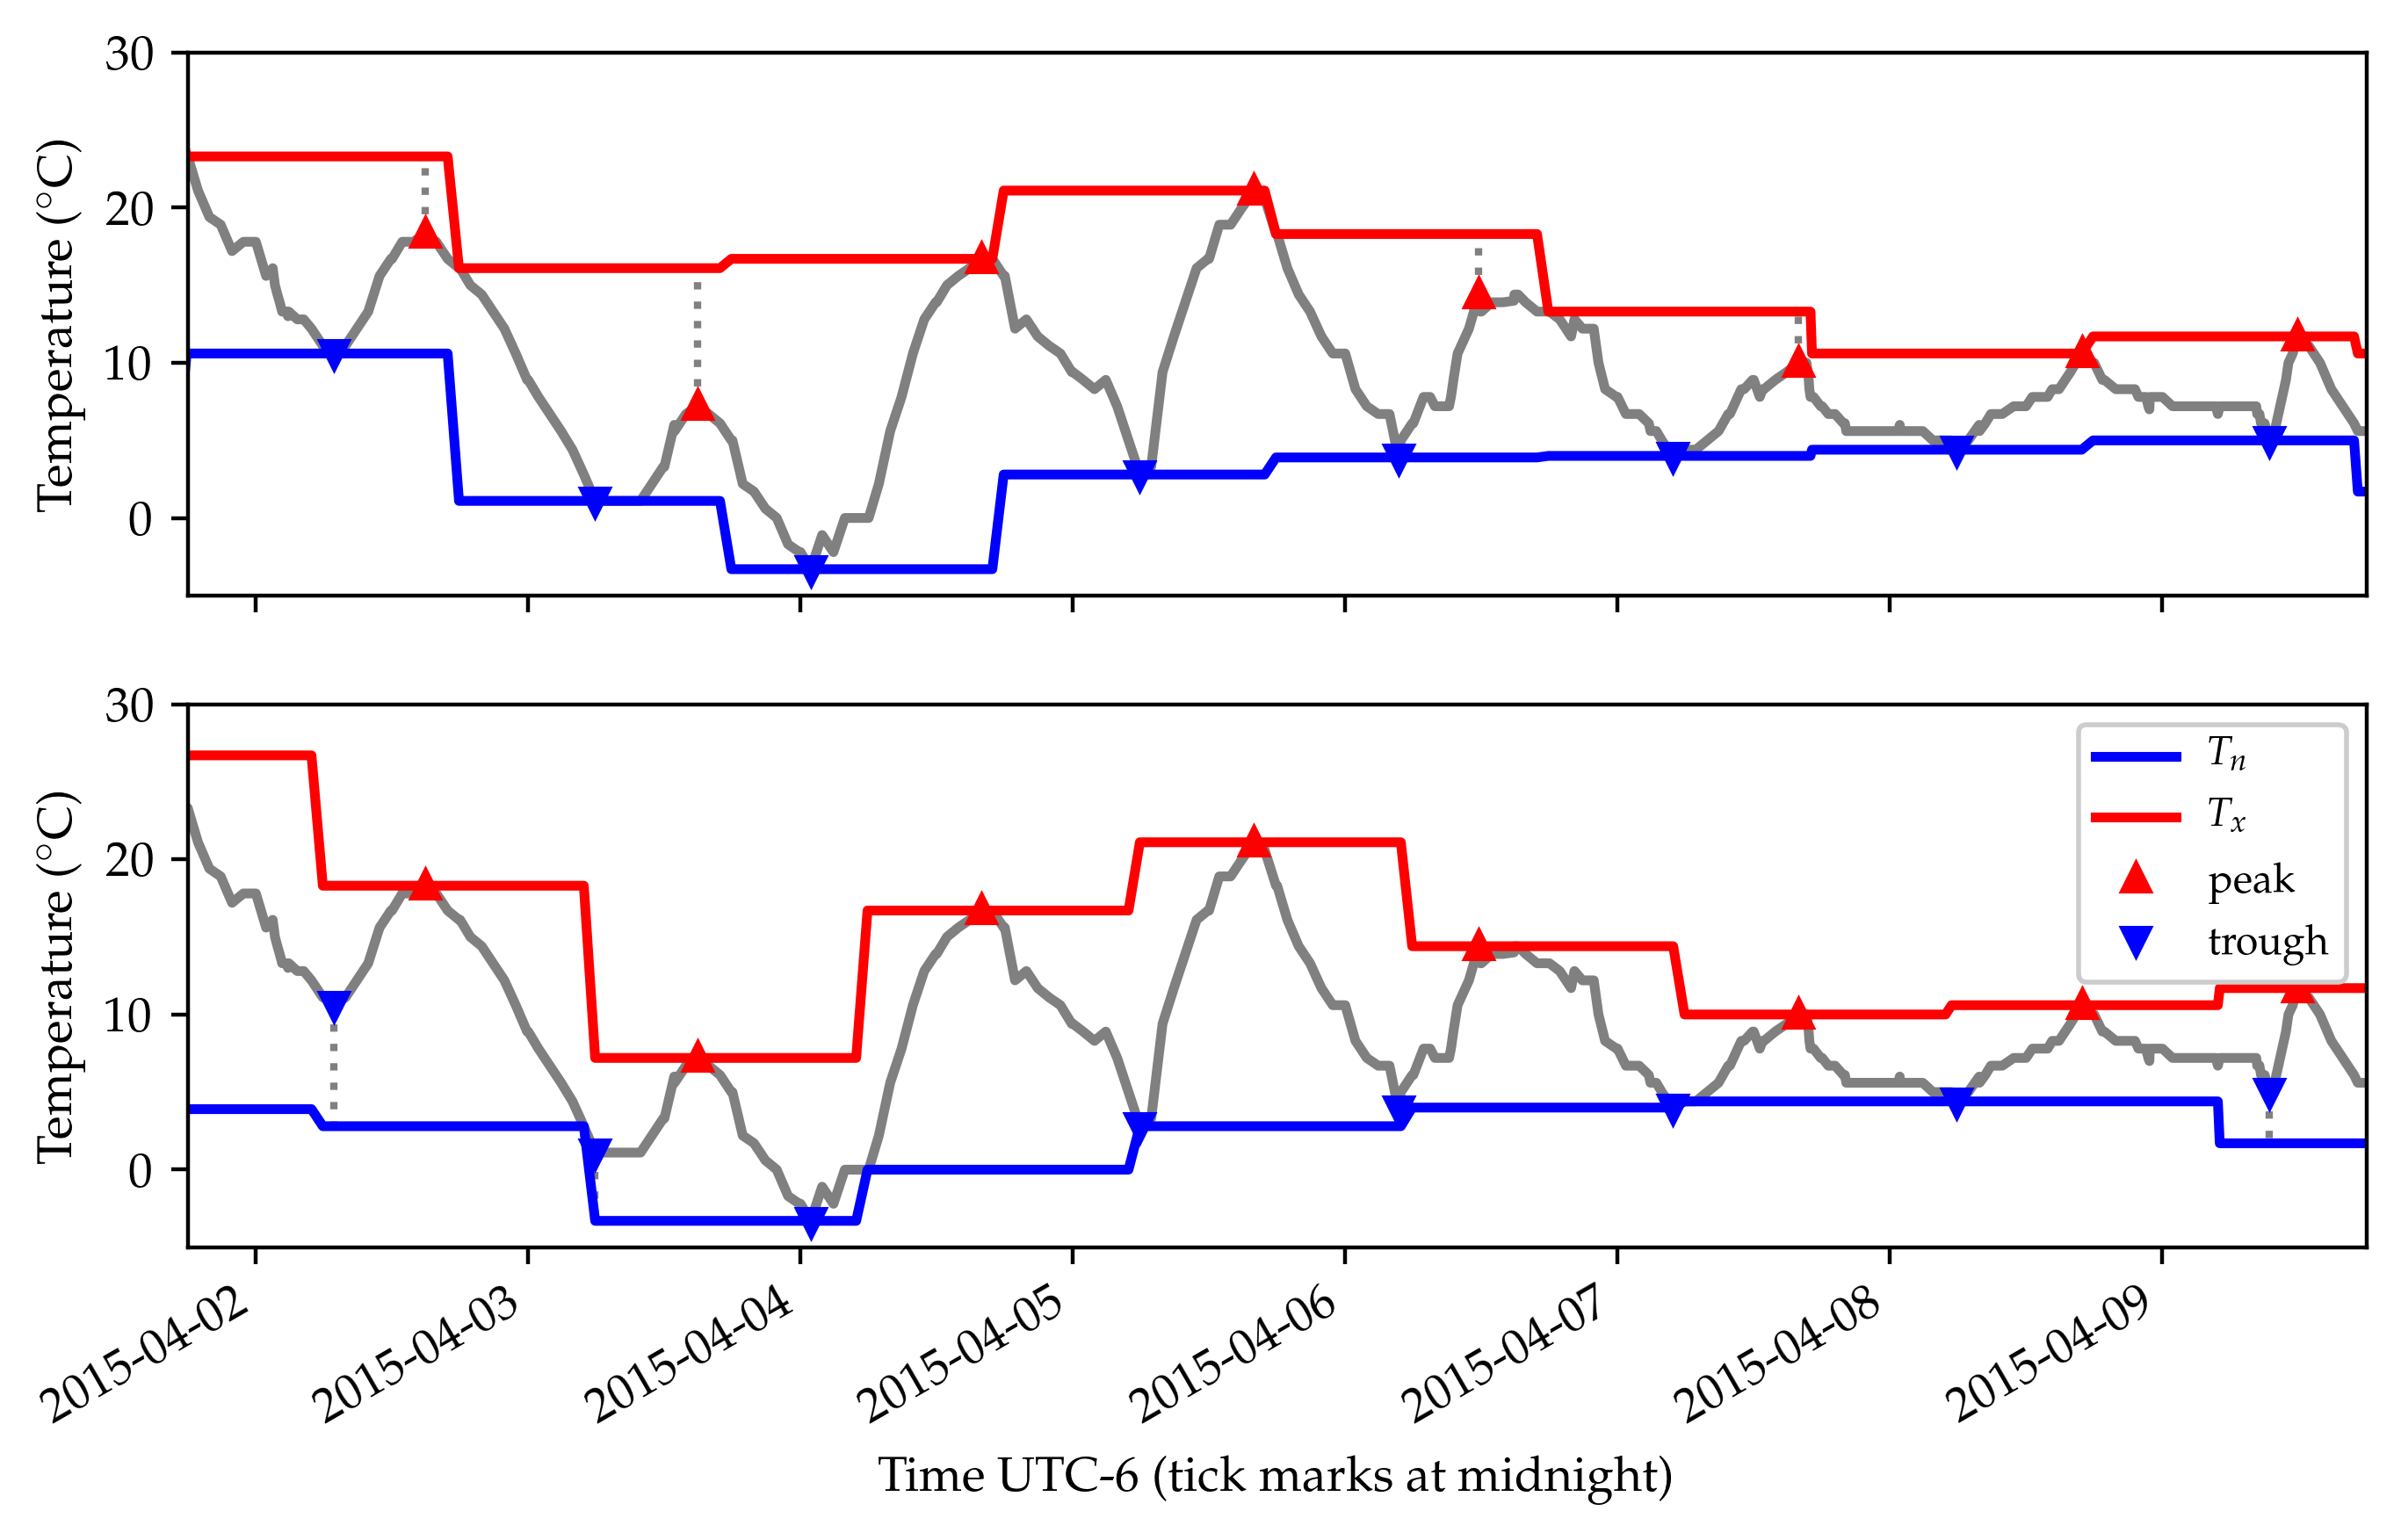

In [7]:
datemin = DateTime(2015,4,2)
datemax = DateTime(2015,4,10)
plt.subplot(2,1,1)
trianglesize = 4
begin
    hr = Hour(17)+Hour(6)
    peak = Hour(14)+Hour(6)
    low = Hour(2)+Hour(6)
    waterloo[!,:ts_day] = [TemperatureImputations.measurement_date(t,hr)
                         for t in waterloo[!,:ts]]
    test_trimmed = leftjoin(waterloo, waterloo_TnTx_dict[hr], on=:ts_day)
    ts_hr = test_trimmed[!,:ts]
    inwindow = ((datemin-Day(1)) .< ts_hr) .& (ts_hr .< (datemax+Day(1)))
    plt.plot(
            iowa_time.(ts_hr[inwindow]), 
            test_trimmed[inwindow,:temp], 
            color="grey", linewidth=2)
    tn_hr = test_trimmed[!,:Tn]
    plt.plot(
            iowa_time.(ts_hr[inwindow]), 
            tn_hr[inwindow], 
            color="blue", linewidth=2, label=L"$T_n$")
    tx_hr = test_trimmed[!,:Tx]
    plt.plot(
            iowa_time.(ts_hr[inwindow]),
            tx_hr[inwindow], 
            color="red", linewidth=2, label=L"$T_x$")
    
    TnTx_low = waterloo_TnTx_dict[low]
    TnTx_peak = waterloo_TnTx_dict[peak]
    plt.plot(
        iowa_time.(TnTx_low[!,:Tx_time]),
        TnTx_low[!,:Tx], 
        linestyle="",
        marker="^", 
        color="red", 
        markeredgewidth=2,
        markersize=trianglesize,
        label="peak"
        )
    plt.plot(
        iowa_time.(TnTx_peak[!,:Tn_time]),
        TnTx_peak[!,:Tn], 
        linestyle="",
        marker="v", 
        color="blue", 
        markeredgewidth=2,
        markersize=trianglesize,
        label="trough"
        )
    labeled_disc = false
    for i in 1:size(TnTx_low, 1)
        txtime = TnTx_low[!,:Tx_time][i]
        tx_low = TnTx_low[!,:Tx][i]
        its = searchsortedfirst(ts_hr, txtime)
        tx_obs = tx_hr[its]
        if tx_low != tx_obs
            if labeled_disc
                label = ""
            else
                label = "discrepancy"
                labeled_disc = true
            end
            plt.plot(iowa_time.([txtime, txtime]), (tx_low, tx_obs), ":", color="grey", 
                     zorder=-1, label=label)
        end
    end
    for i in 1:size(TnTx_peak, 1)
        tntime = TnTx_peak[!,:Tn_time][i]
        tn_low = TnTx_peak[!,:Tn][i]
        its = searchsortedfirst(ts_hr, tntime)
        tn_obs = tn_hr[its]
        if tn_low != tn_obs
            if labeled_disc
                label = ""
            else
                label = "discrepancy"
                labeled_disc = true
            end
            plt.plot(iowa_time.([tntime, tntime]), (tn_low, tn_obs), ":", color="grey", 
                     zorder=-1, label=label)
        end
    end
    plt.xlim(iowa_time.([datemin, datemax])) # random interval
    plt.ylim(-5,30)
    plt.ylabel(L"Temperature ($^{\circ}$C)")
#     plt.legend()
end
plt.gca()[:set_xticklabels]([])
plt.subplot(2,1,2)
begin
    hr = Hour(5)+Hour(6)
    peak = Hour(14)+Hour(6)
    low = Hour(2)+Hour(6)
    waterloo[!,:ts_day] = [TemperatureImputations.measurement_date(t,hr)
                         for t in waterloo[!,:ts]]
    test_trimmed = leftjoin(waterloo, waterloo_TnTx_dict[hr], on=:ts_day)
    ts_hr = test_trimmed[!,:ts]
    inwindow = ((datemin-Day(1)) .< ts_hr) .& (ts_hr .< (datemax+Day(1)))
    plt.plot(
            iowa_time.(ts_hr[inwindow]), 
            test_trimmed[inwindow,:temp], 
            color="grey", linewidth=2)
    tn_hr = test_trimmed[!,:Tn]
    plt.plot(
            iowa_time.(ts_hr[inwindow]), 
            tn_hr[inwindow], 
            color="blue", linewidth=2, label=L"$T_n$")
    tx_hr = test_trimmed[!,:Tx]
    plt.plot(
            iowa_time.(ts_hr[inwindow]),
            tx_hr[inwindow], 
            color="red", linewidth=2, label=L"$T_x$")
    
    TnTx_low = waterloo_TnTx_dict[low]
    TnTx_peak = waterloo_TnTx_dict[peak]
    plt.plot(
        iowa_time.(TnTx_low[!,:Tx_time]),
        TnTx_low[!,:Tx], 
        linestyle="",
        marker="^", 
        color="red", 
        markeredgewidth=2,
        markersize=trianglesize,
        label="peak"
        )
    plt.plot(
        iowa_time.(TnTx_peak[!,:Tn_time]),
        TnTx_peak[!,:Tn], 
        linestyle="",
        marker="v", 
        color="blue", 
        markeredgewidth=2,
        markersize=trianglesize,
        label="trough"
        )
    labeled_disc = false
    for i in 1:size(TnTx_low, 1)
        txtime = TnTx_low[!,:Tx_time][i]
        tx_low = TnTx_low[!,:Tx][i]
        its = searchsortedfirst(ts_hr, txtime)
        tx_obs = tx_hr[its]
        if tx_low != tx_obs
            if labeled_disc
                label = ""
            else
                # label = "discrepancy"
                label = ""
                labeled_disc = true
            end
            plt.plot(iowa_time.([txtime, txtime]), (tx_low, tx_obs), ":", color="grey", 
                     zorder=-1, label=label)
        end
    end
    for i in 1:size(TnTx_peak, 1)
        tntime = TnTx_peak[!,:Tn_time][i]
        tn_low = TnTx_peak[!,:Tn][i]
        its = searchsortedfirst(ts_hr, tntime)
        tn_obs = tn_hr[its]
        if tn_low != tn_obs
            if labeled_disc
                label = ""
            else
                # label = "discrepancy"
                label = ""
                labeled_disc = true
            end
            plt.plot(iowa_time.([tntime, tntime]), (tn_low, tn_obs), ":", color="grey", 
                     zorder=-1, label=label)
        end
    end
    plt.xlim(iowa_time.([datemin, datemax])) # random interval
    plt.ylim(-5,30)
    plt.ylabel(L"Temperature ($^{\circ}$C)")
    leg = plt.legend(loc="upper right", fontsize="small")
    leg[:get_frame]()[:set_alpha](1.0)
end
plt.xlabel("Time UTC-6 (tick marks at midnight)")
plt.gcf()[:autofmt_xdate]()
plt.savefig("../figures/waterloo_triangles.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_triangles.pdf", bbox_inches="tight")

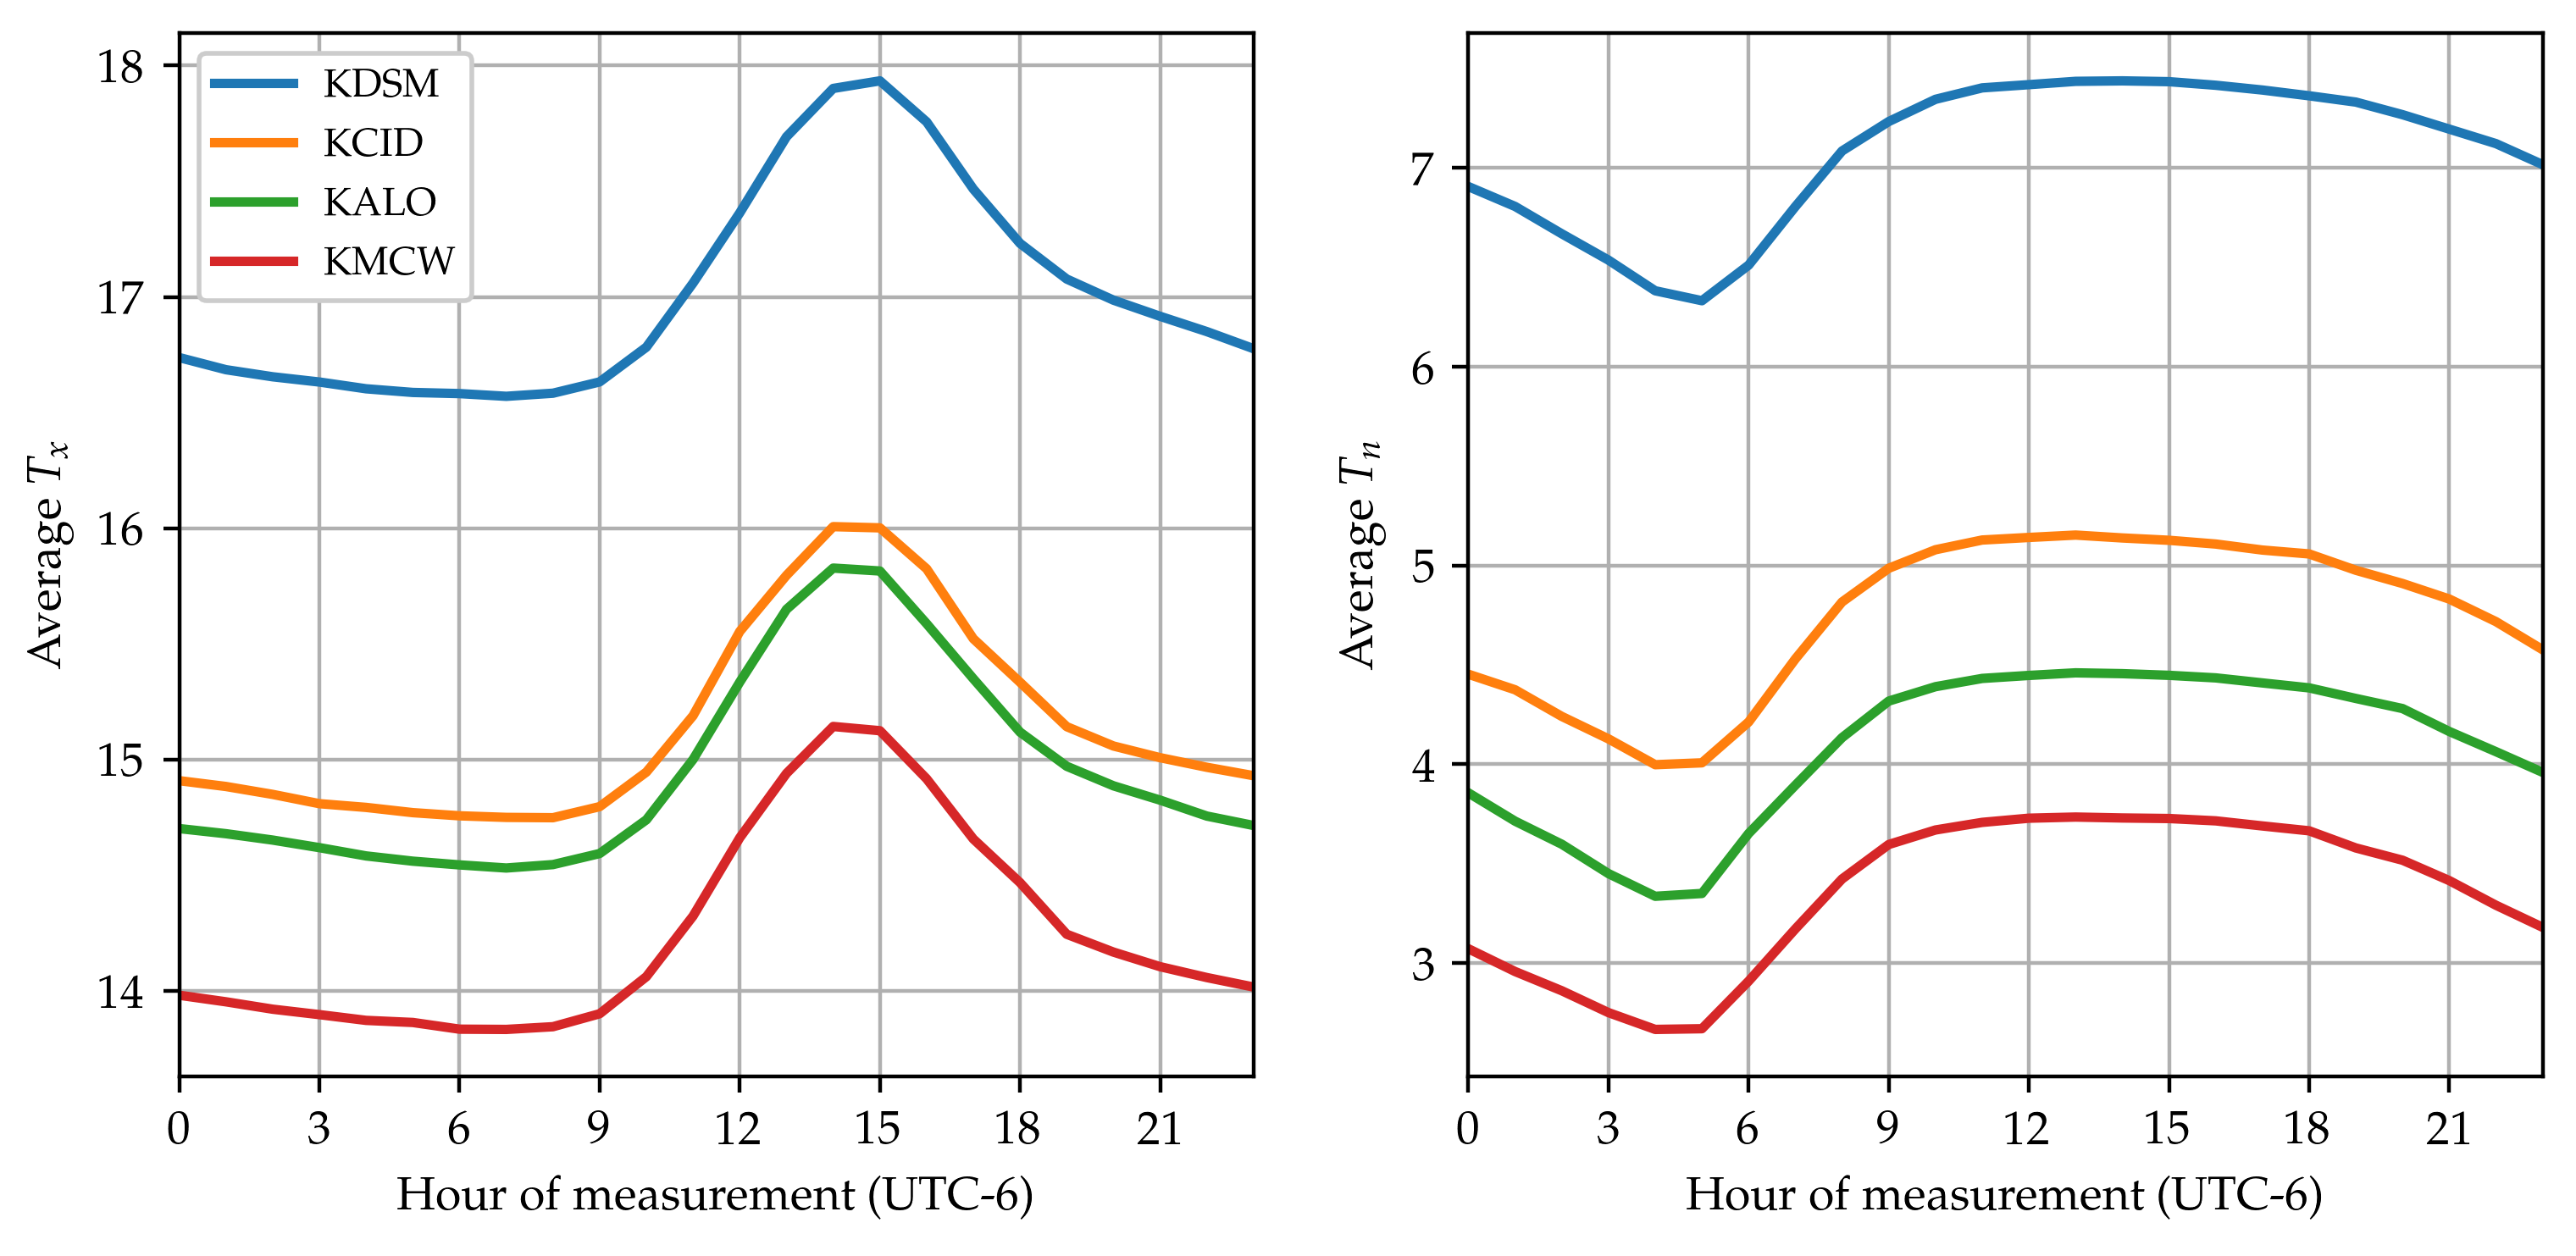

In [8]:
begin
plt.subplot(1,2,1)
hours = Hour(0):Hour(1):Hour(23)
ilocaltime = circshift(1:24, -6)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in Hour(0):Hour(1):Hour(24)
            TnTx = TnTx_dict[istation][hr]
            push!(statdict[istation], mean(TnTx[!,:Tx]))
        end
    end

    for station in [2,1,3,4]
        plt.plot(0:23, statdict[station][ilocaltime], linewidth=2, label=isdSubset[station,:ICAO])
    end
    plt.ylabel(L"Average $T_x$")
    plt.xlabel("Hour of measurement (UTC-6)")
#     plt.title("Average daily maximum in 2015 as a function of the measurement hour")
    plt.grid(true)
    leg = plt.legend(loc="upper left", fontsize="small")
    leg[:get_frame]()[:set_alpha](1.0)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.subplot(1,2,2)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            push!(statdict[istation], mean(TnTx[!,:Tn]))
        end
    end

    for station in [2,1,3,4]
        plt.plot(0:23, statdict[station][ilocaltime], linewidth=2, label=isdSubset[station,:ICAO])
    end
    plt.ylabel(L"Average $T_n$")
    plt.xlabel("Hour of measurement (UTC-6)")
#     plt.title("Average daily minimum in 2015 as a function of the measurement hour")
    plt.grid(true)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.gcf()[:set_size_inches](9.0, 4.0)
plt.savefig("../figures/waterloo_avgTnTx.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_avgTnTx.pdf", bbox_inches="tight")
end;

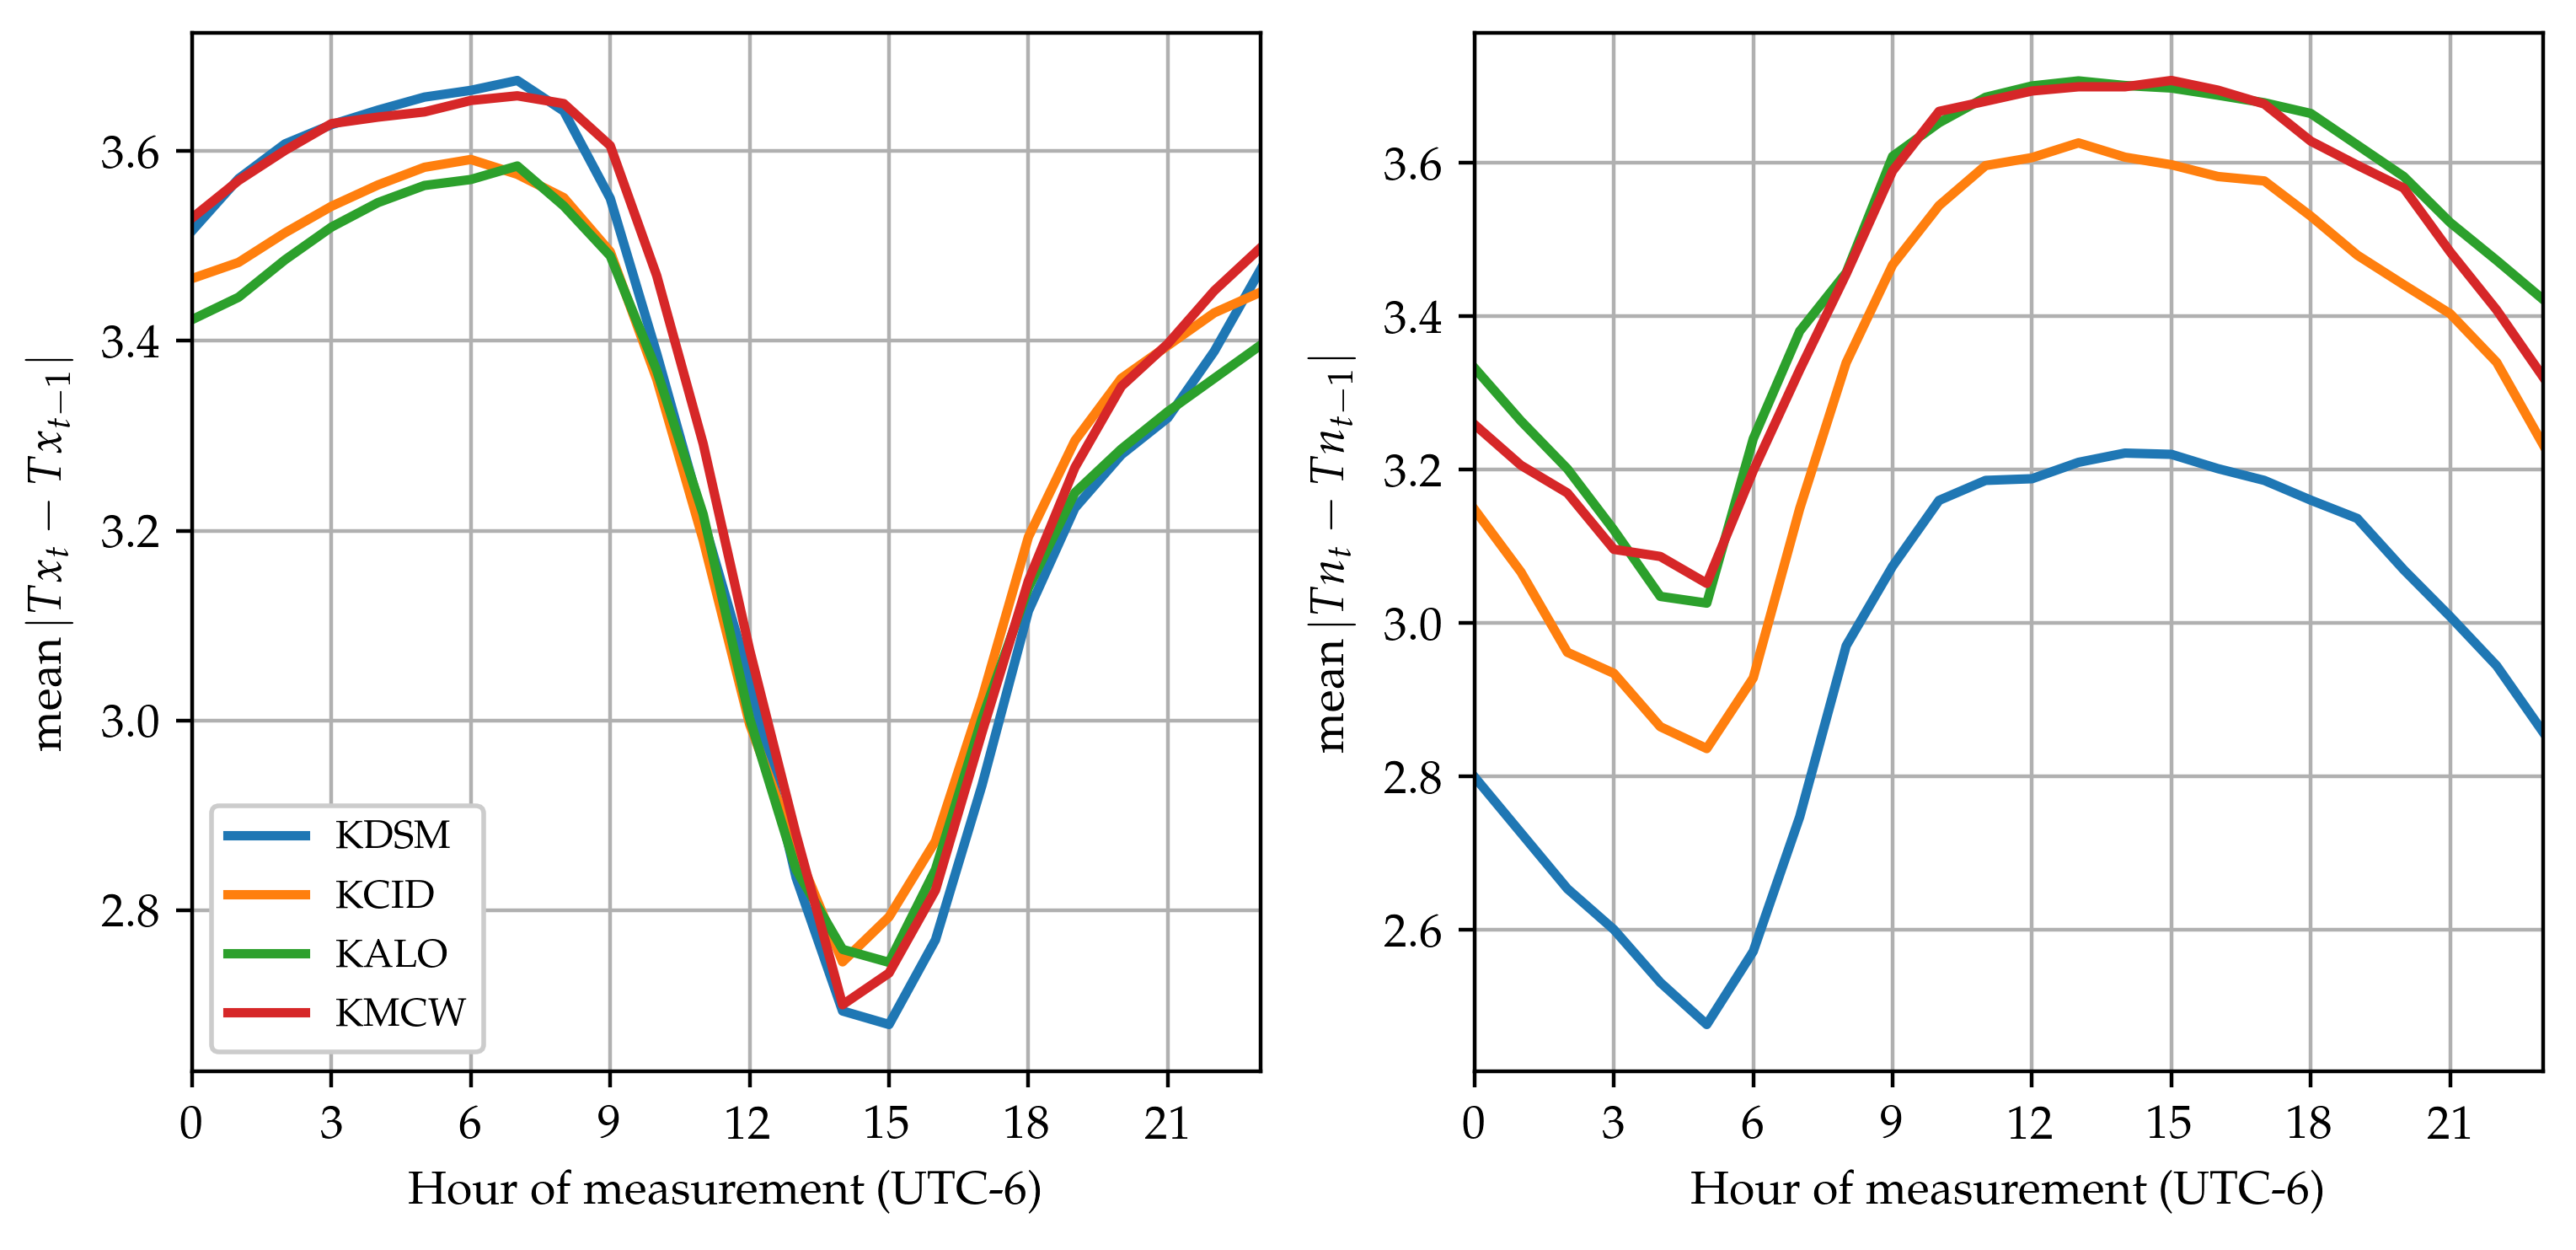

In [9]:
plt.subplot(1,2,1)
hours = Hour(0):Hour(1):Hour(23)
ilocaltime = circshift(1:24, -6)
begin
    meandiff = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            push!(meandiff[istation], mean(abs.(diff(TnTx.Tx))))
        end
    end

    for station in [2,1,3,4]
        plt.plot(0:23, meandiff[station][ilocaltime], linewidth=2, label=isdSubset[station,:ICAO])
    end
    plt.ylabel(L"$\mathrm{mean}\left| Tx_{t}-Tx_{t-1} \right|$")
#     plt.title("Mean absolute change in daily maximum temperature in 2015")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid()
    leg = plt.legend(loc="lower left", fontsize="small")
    leg[:get_frame]()[:set_alpha](1.0)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.subplot(1,2,2)
begin
    meandiff = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            push!(meandiff[istation], mean(abs.(diff(TnTx.Tn))))
        end
    end

    for station in [2,1,3,4]
        plt.plot(0:23, meandiff[station][ilocaltime], linewidth=2)
    end
    plt.ylabel(L"$\mathrm{mean}\left| Tn_{t}-Tn_{t-1} \right|$")
#     plt.title("Mean absolute change in daily minimum temperature in 2015")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid(true)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.gcf()[:set_size_inches](9.0, 4.0)
plt.savefig("../figures/waterloo_meanabsdiff.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_meanabsdiff.pdf", bbox_inches="tight")
;

## 2x2 bias plot

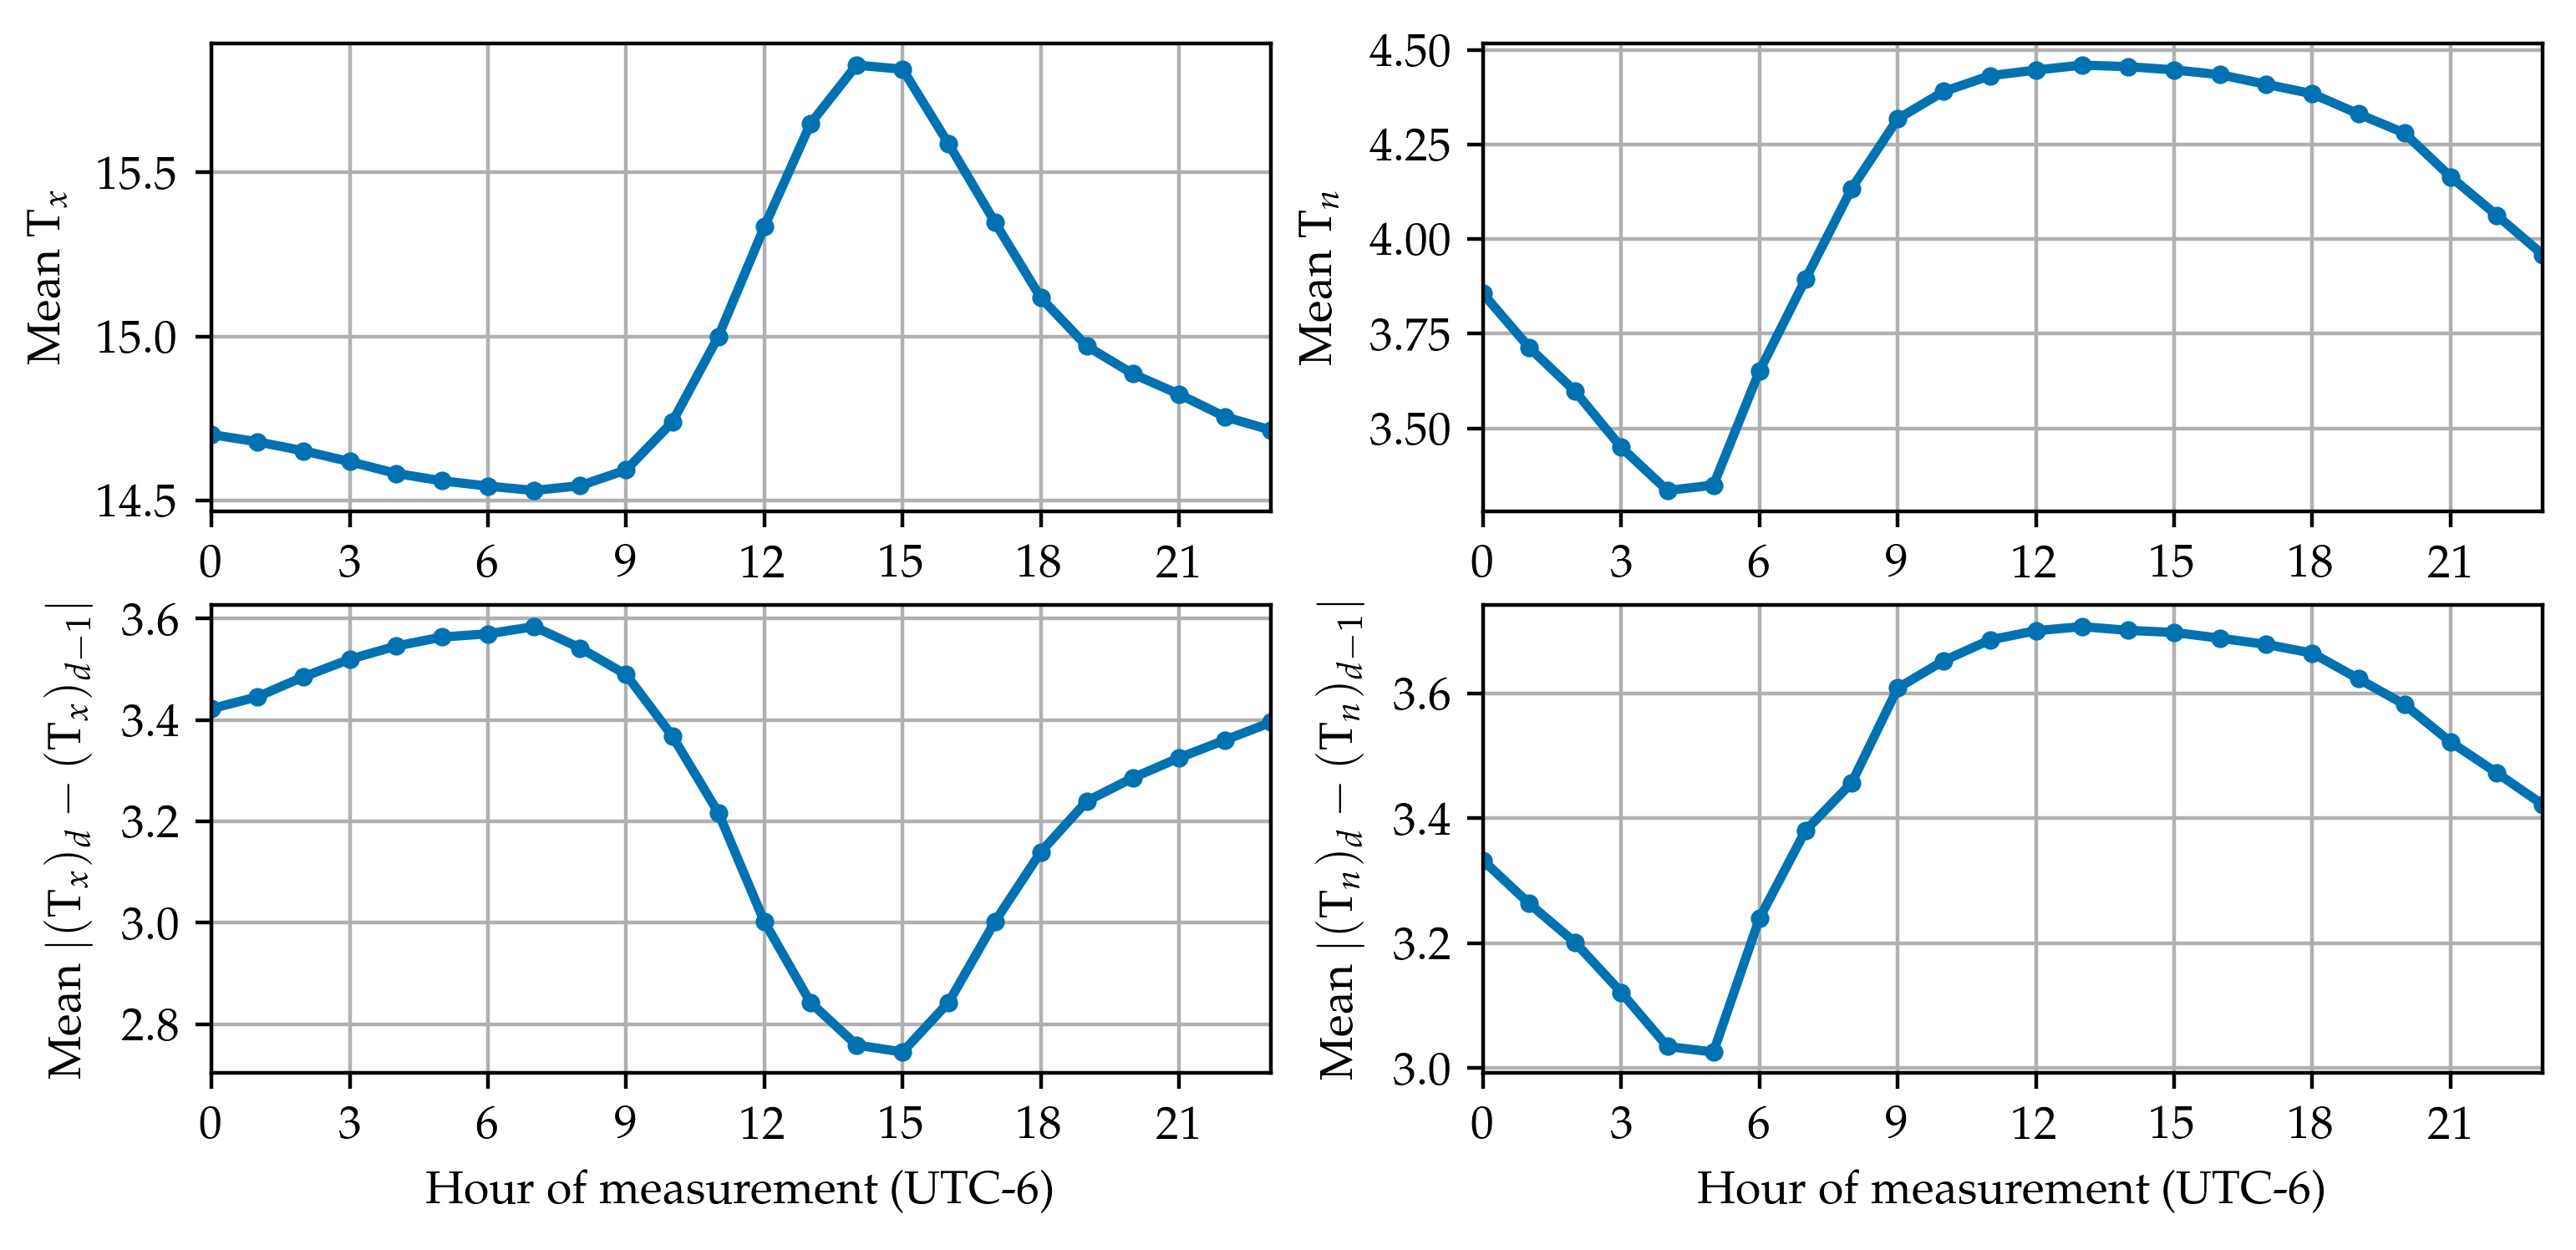

In [10]:
begin
color = cbbPalette[5]
plt.subplot(2,2,1)
hours = Hour(0):Hour(1):Hour(23)
ilocaltime = circshift(1:24, -6)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in Hour(0):Hour(1):Hour(24)
            TnTx = TnTx_dict[istation][hr]
            push!(statdict[istation], mean(TnTx.Tx))
        end
    end

    for station in [3]
        plt.plot(0:23, statdict[station][ilocaltime], ".-", color=color, linewidth=2, label=isdSubset[station,:ICAO])
    end
    plt.ylabel(L"Mean $\mathrm{T}_x$")
#     plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid(true)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.subplot(2,2,2)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            push!(statdict[istation], mean(TnTx.Tn))
        end
    end

    for station in [3]
        plt.plot(0:23, statdict[station][ilocaltime], ".-", color=color, linewidth=2, label=isdSubset[station,:ICAO])
    end
    plt.ylabel(L"Mean $\mathrm{T}_n$")
#     plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid(true)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end

plt.subplot(2,2,3)
hours = Hour(0):Hour(1):Hour(23)
ilocaltime = circshift(1:24, -6)
begin
    meandiff = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            push!(meandiff[istation], mean(abs.(diff(TnTx.Tx))))
        end
    end

    for station in [3]
        plt.plot(0:23, meandiff[station][ilocaltime], ".-", color=color, linewidth=2, label=isdSubset[station,:ICAO])
    end
    plt.ylabel(L"Mean $\left| (\mathrm{T}_x)_{d}-(\mathrm{T}_x)_{d-1} \right|$")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid()
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.subplot(2,2,4)
begin
    meandiff = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            push!(meandiff[istation], mean(abs.(diff(TnTx.Tn))))
        end
    end

    for station in [3]
        plt.plot(0:23, meandiff[station][ilocaltime], ".-", color=color, linewidth=2)
    end
    plt.ylabel(L"Mean $\left| (\mathrm{T}_n)_{d}-(\mathrm{T}_n)_{d-1} \right|$")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid(true)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.gcf()[:set_size_inches](9.0, 4.0)
plt.savefig("../figures/waterloo_bias_2x2.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_bias_2x2.pdf", bbox_inches="tight")
end
;

## Variance plot

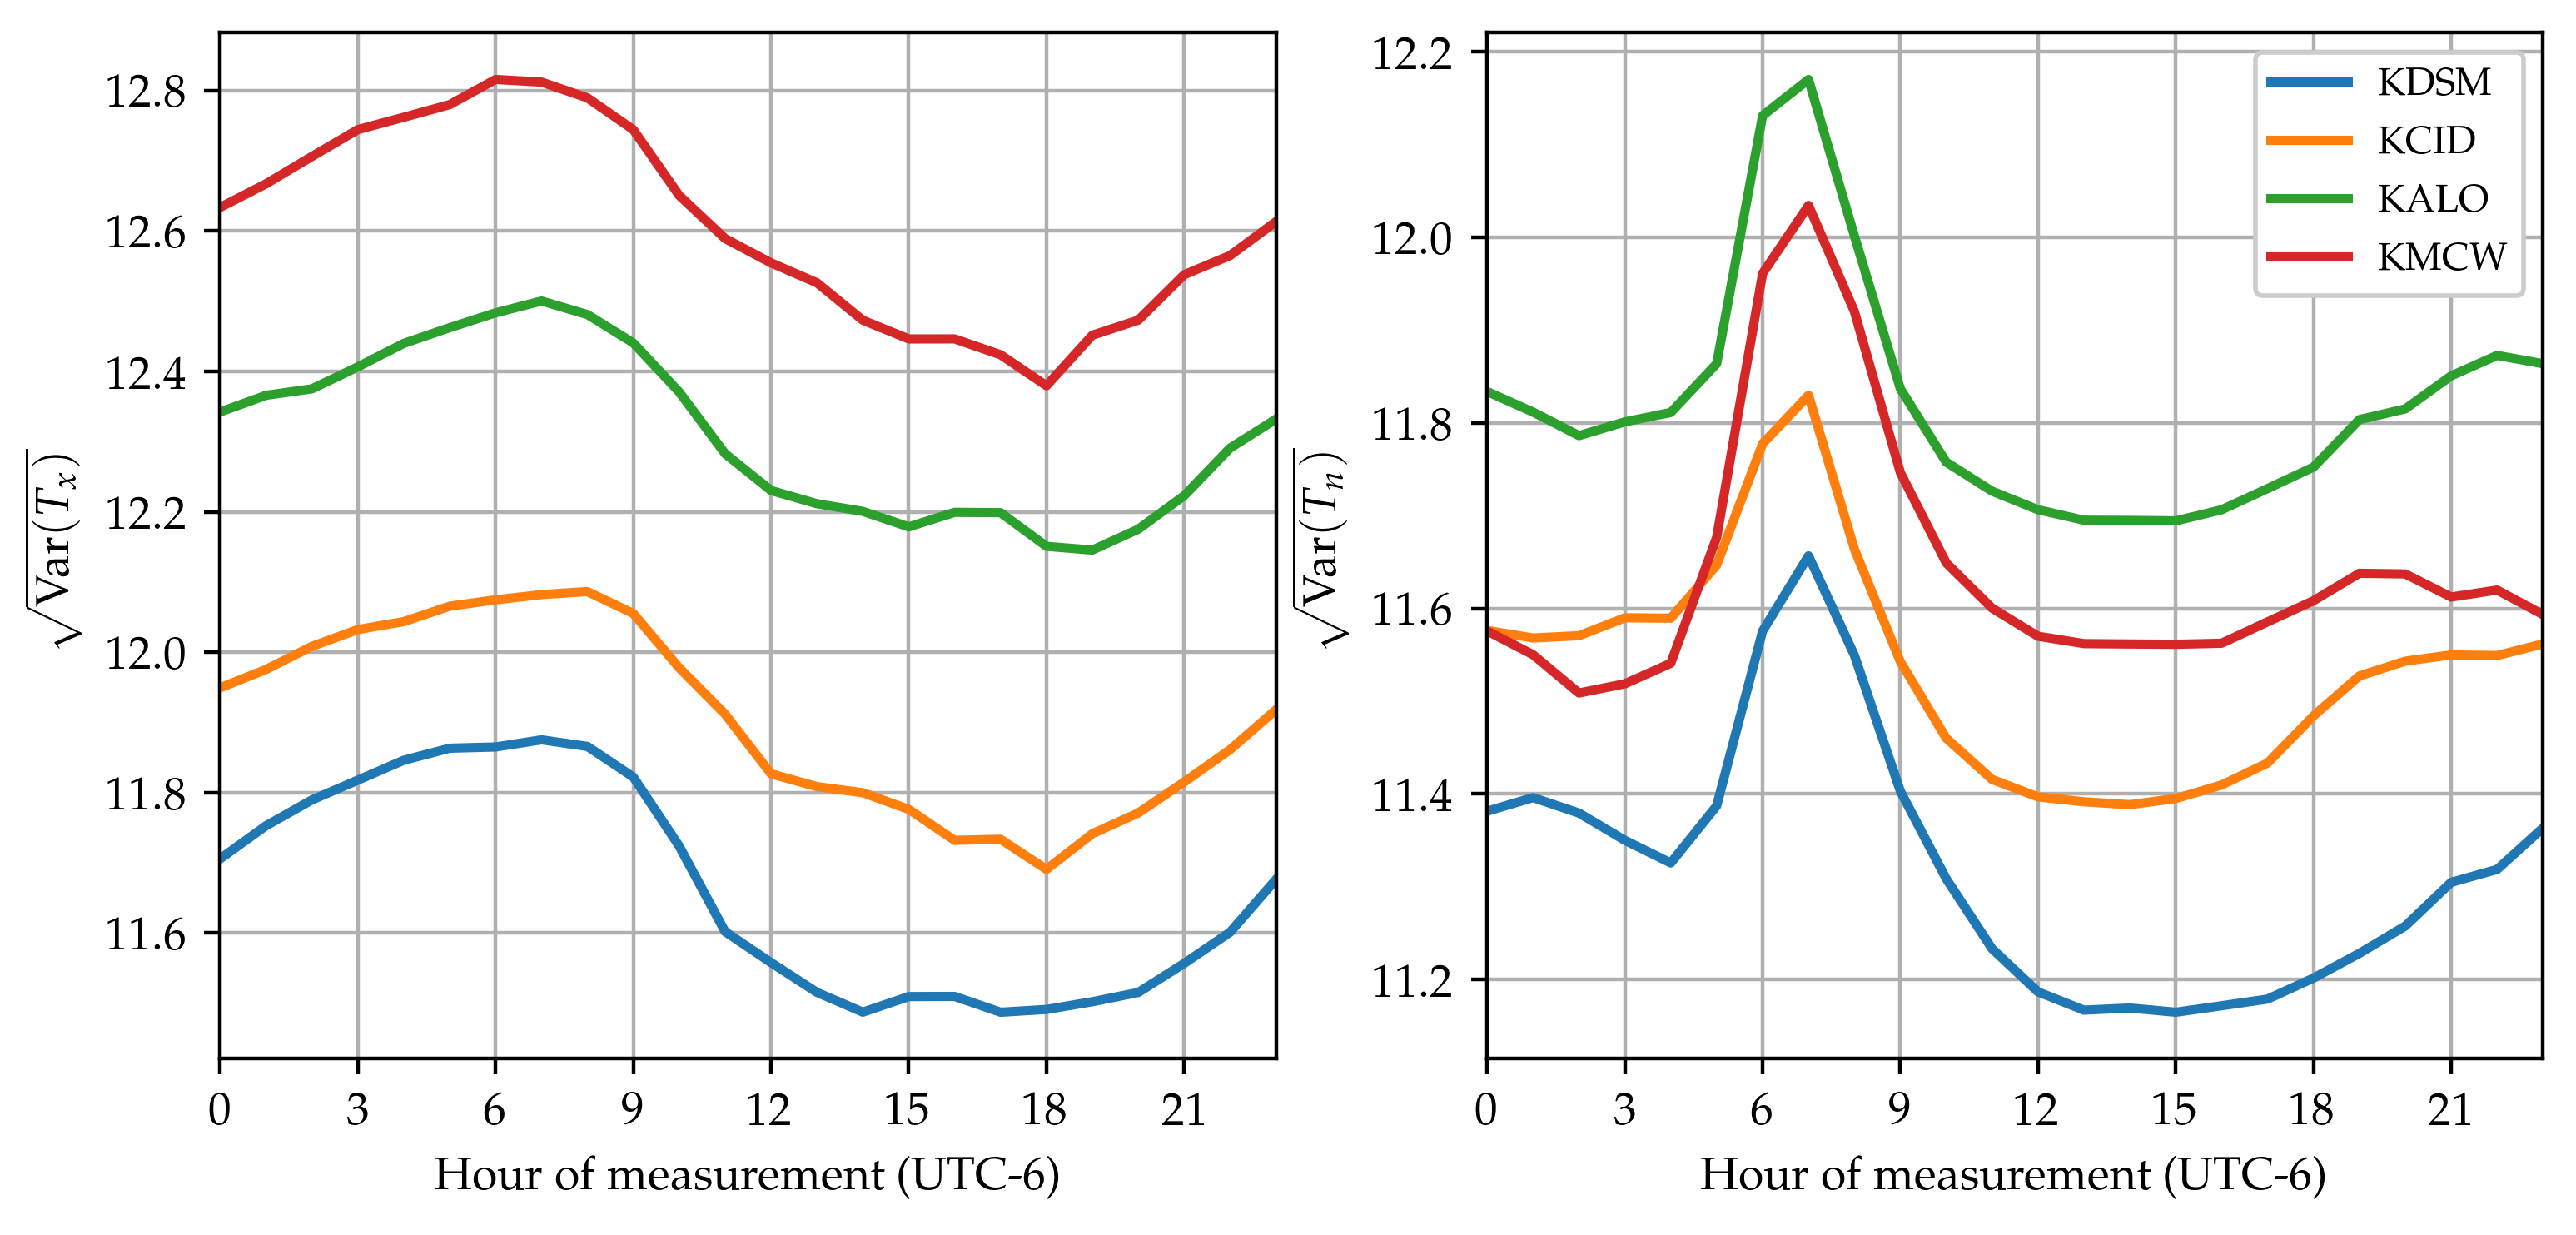

In [11]:
plt.subplot(1,2,1)
hours = Hour(0):Hour(1):Hour(23)
ilocaltime = circshift(1:24, -6)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            push!(statdict[istation], var(TnTx.Tx))
        end
    end

    for station in (2,1,3,4)
        plt.plot(0:23, sqrt.(statdict[station][ilocaltime]), linewidth=2, label=isdSubset[station,:ICAO])
    end
    plt.ylabel(L"$\sqrt{\mathrm{Var}(T_x)}$")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid()
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
end
plt.subplot(1,2,2)
begin
    statdict = Dict{Int64, Vector{Float64}}(
        1=>Float64[],
        2=>Float64[],
        3=>Float64[],
        4=>Float64[]
        )
    for istation in 1:4
        for hr in hours
            TnTx = TnTx_dict[istation][hr]
            push!(statdict[istation], var(TnTx.Tn))
        end
    end

    for station in (2,1,3,4)
        plt.plot(0:23, sqrt.(statdict[station][ilocaltime]), linewidth=2, label=isdSubset[station,:ICAO])
    end
    plt.ylabel(L"$\sqrt{\mathrm{Var}(T_n)}$")
    plt.xlabel("Hour of measurement (UTC-6)")
    plt.grid(true)
    plt.xticks(0:3:24)
    plt.xlim(0, 23)
    leg = plt.legend(loc="upper right", fontsize="small")
    leg[:get_frame]()[:set_alpha](1.0)
end
plt.gcf()[:set_size_inches](9.0, 4.0)
plt.savefig("../figures/waterloo_var.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_var.pdf", bbox_inches="tight")
;

## Quantile plots (90% and 95% range)

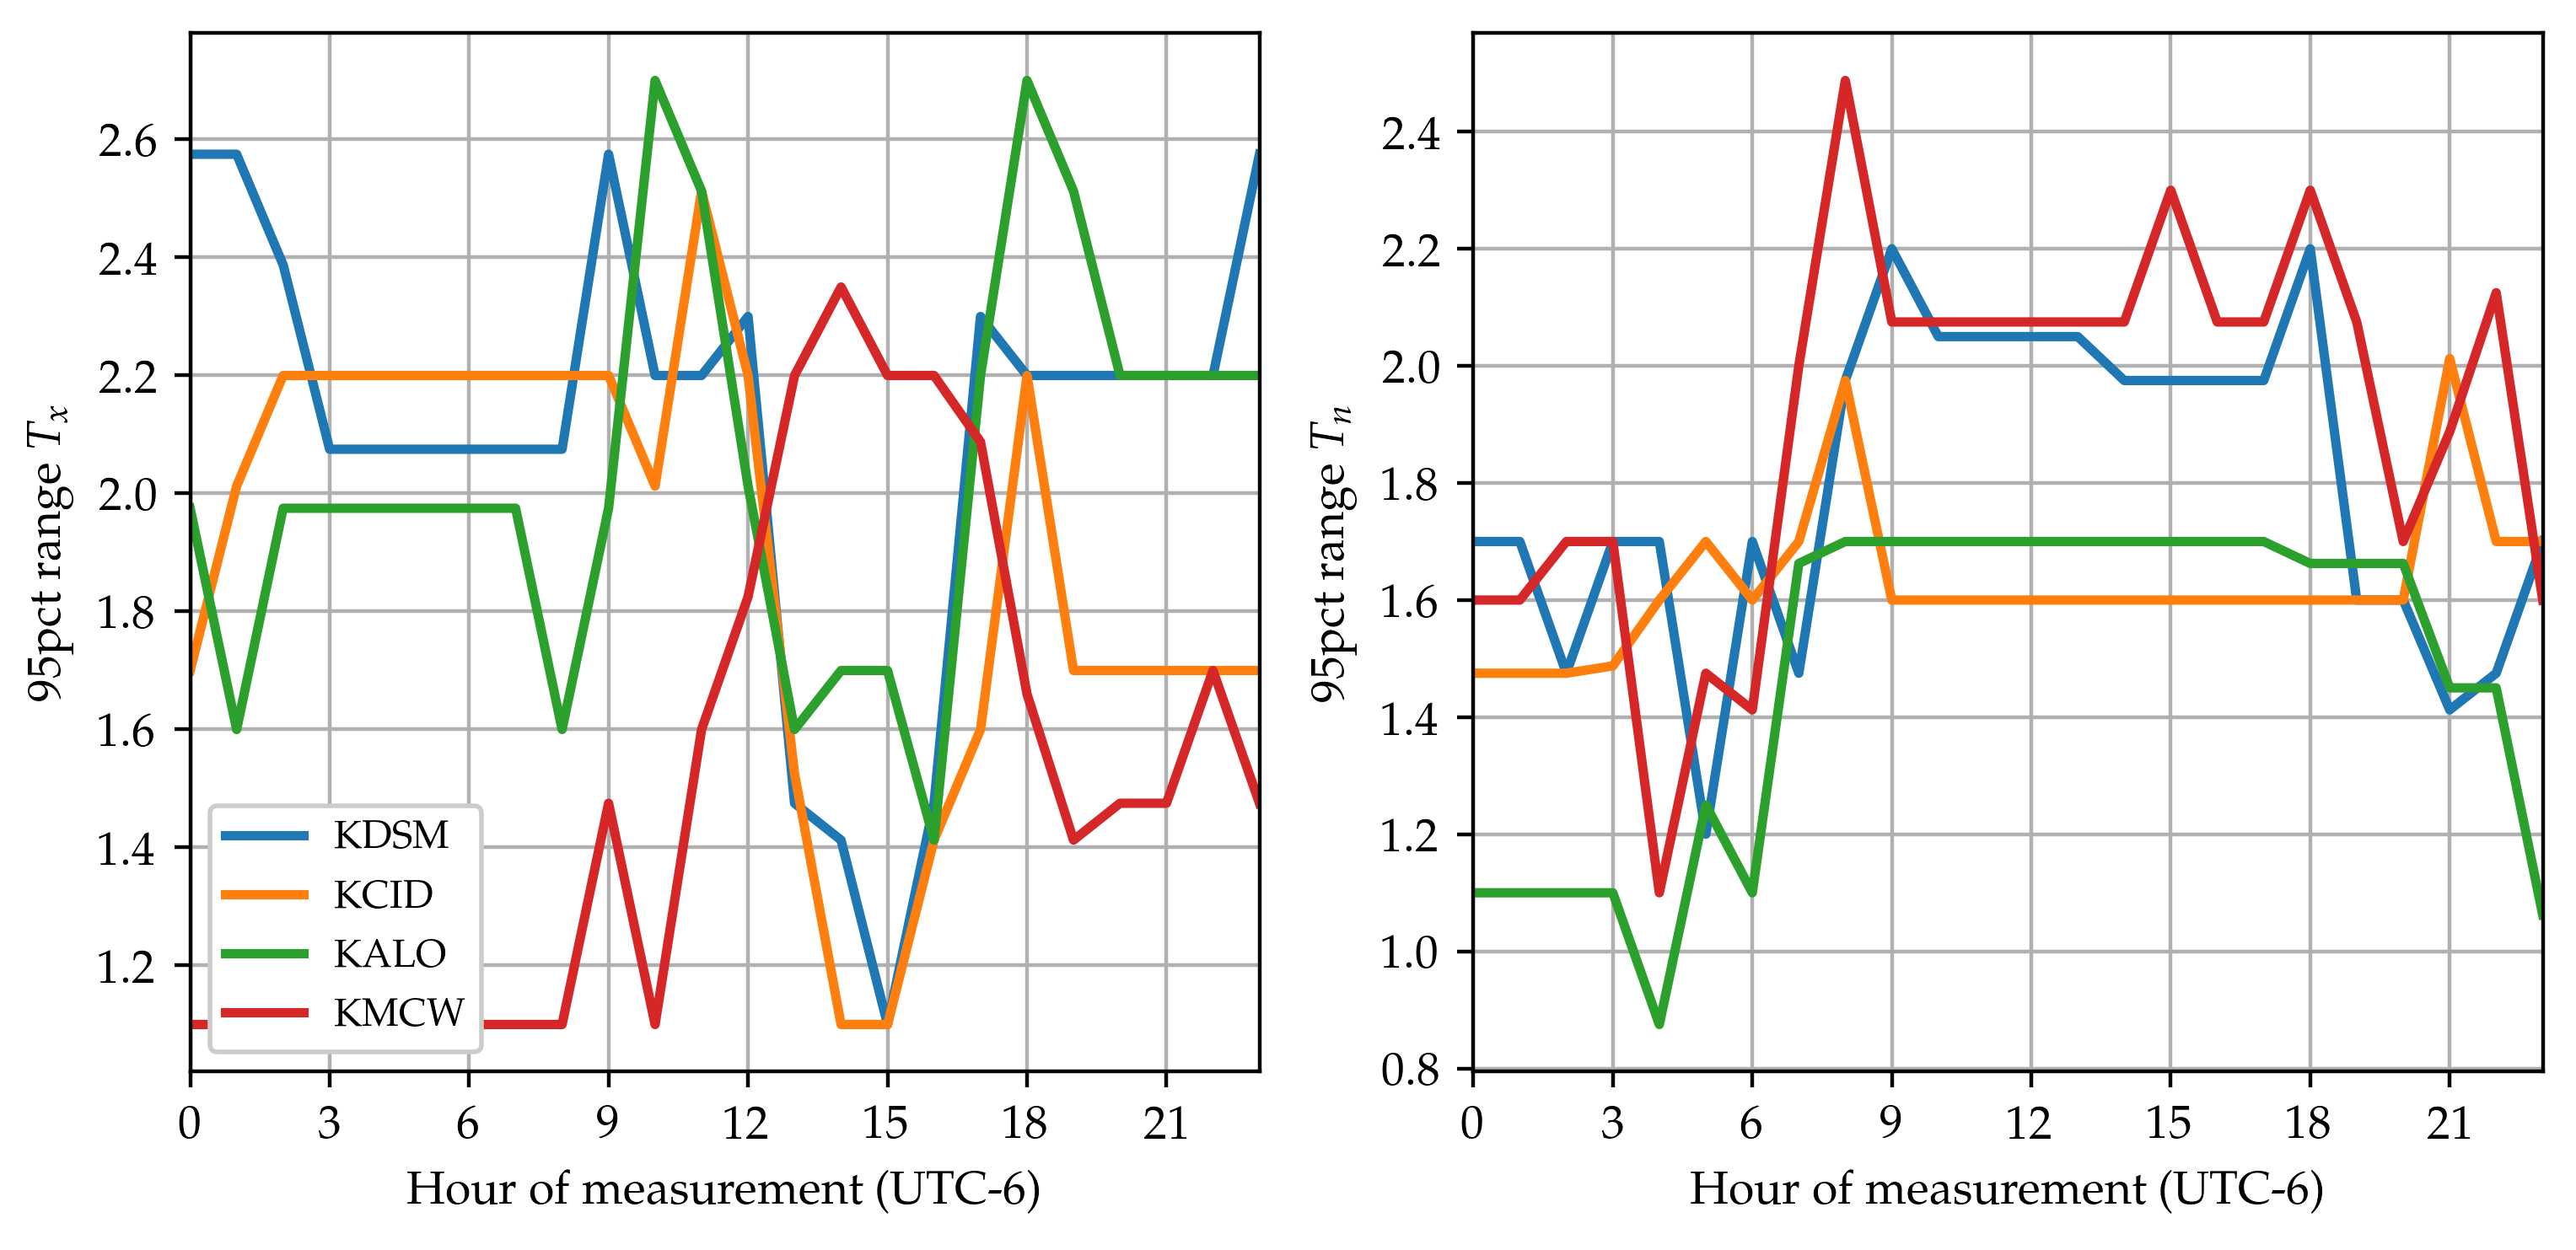

In [12]:
function quantile_plot(pctrange)
    plt.subplot(1,2,1)
    hours = Hour(0):Hour(1):Hour(23)
    ilocaltime = circshift(1:24, -6)
    begin
        statdict = Dict{Int64, Vector{Float64}}(
            1=>Float64[],
            2=>Float64[],
            3=>Float64[],
            4=>Float64[]
            )
        for istation in 1:4
            for hr in hours
                TnTx = TnTx_dict[istation][hr]
                y = TnTx.Tx
                perc975 = quantile(y, 1-pctrange/100/2)
                perc025 = quantile(y, pctrange/100/2)
                push!(statdict[istation], perc975-perc025)
            end
        end

        for station in (2,1,3,4)
            plt.plot(0:23, statdict[station][ilocaltime], linewidth=2, label=isdSubset[station,:ICAO])
        end
        plt.ylabel(string(pctrange)*L"pct range $T_x$")
        plt.xlabel("Hour of measurement (UTC-6)")
        plt.grid()
        leg = plt.legend(loc="lower left", fontsize="small")
        leg.get_frame().set_alpha(1.0)
        plt.xticks(0:3:24)
        plt.xlim(0, 23)
    end
    plt.subplot(1,2,2)
    begin
        statdict = Dict{Int64, Vector{Float64}}(
            1=>Float64[],
            2=>Float64[],
            3=>Float64[],
            4=>Float64[]
            )
        for istation in (2,1,3,4)
            for hr in hours
                TnTx = TnTx_dict[istation][hr]
                y = TnTx.Tn
                perc975 = quantile(y, 1-pctrange/100/2)
                perc025 = quantile(y, pctrange/100/2)
                push!(statdict[istation], perc975-perc025)
            end
        end

        for station in 1:4
            plt.plot(0:23, statdict[station][ilocaltime], linewidth=2, label=isdSubset[station,:ICAO])
        end
        plt.ylabel(string(pctrange)*L"pct range $T_n$")
        plt.xlabel("Hour of measurement (UTC-6)")
        plt.grid(true)
        plt.xticks(0:3:24)
        plt.xlim(0, 23)
    end
end
quantile_plot(95)
plt.gcf()[:set_size_inches](9.0, 4.0)
plt.savefig("../figures/waterloo_95range.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_95range.pdf", bbox_inches="tight")
;

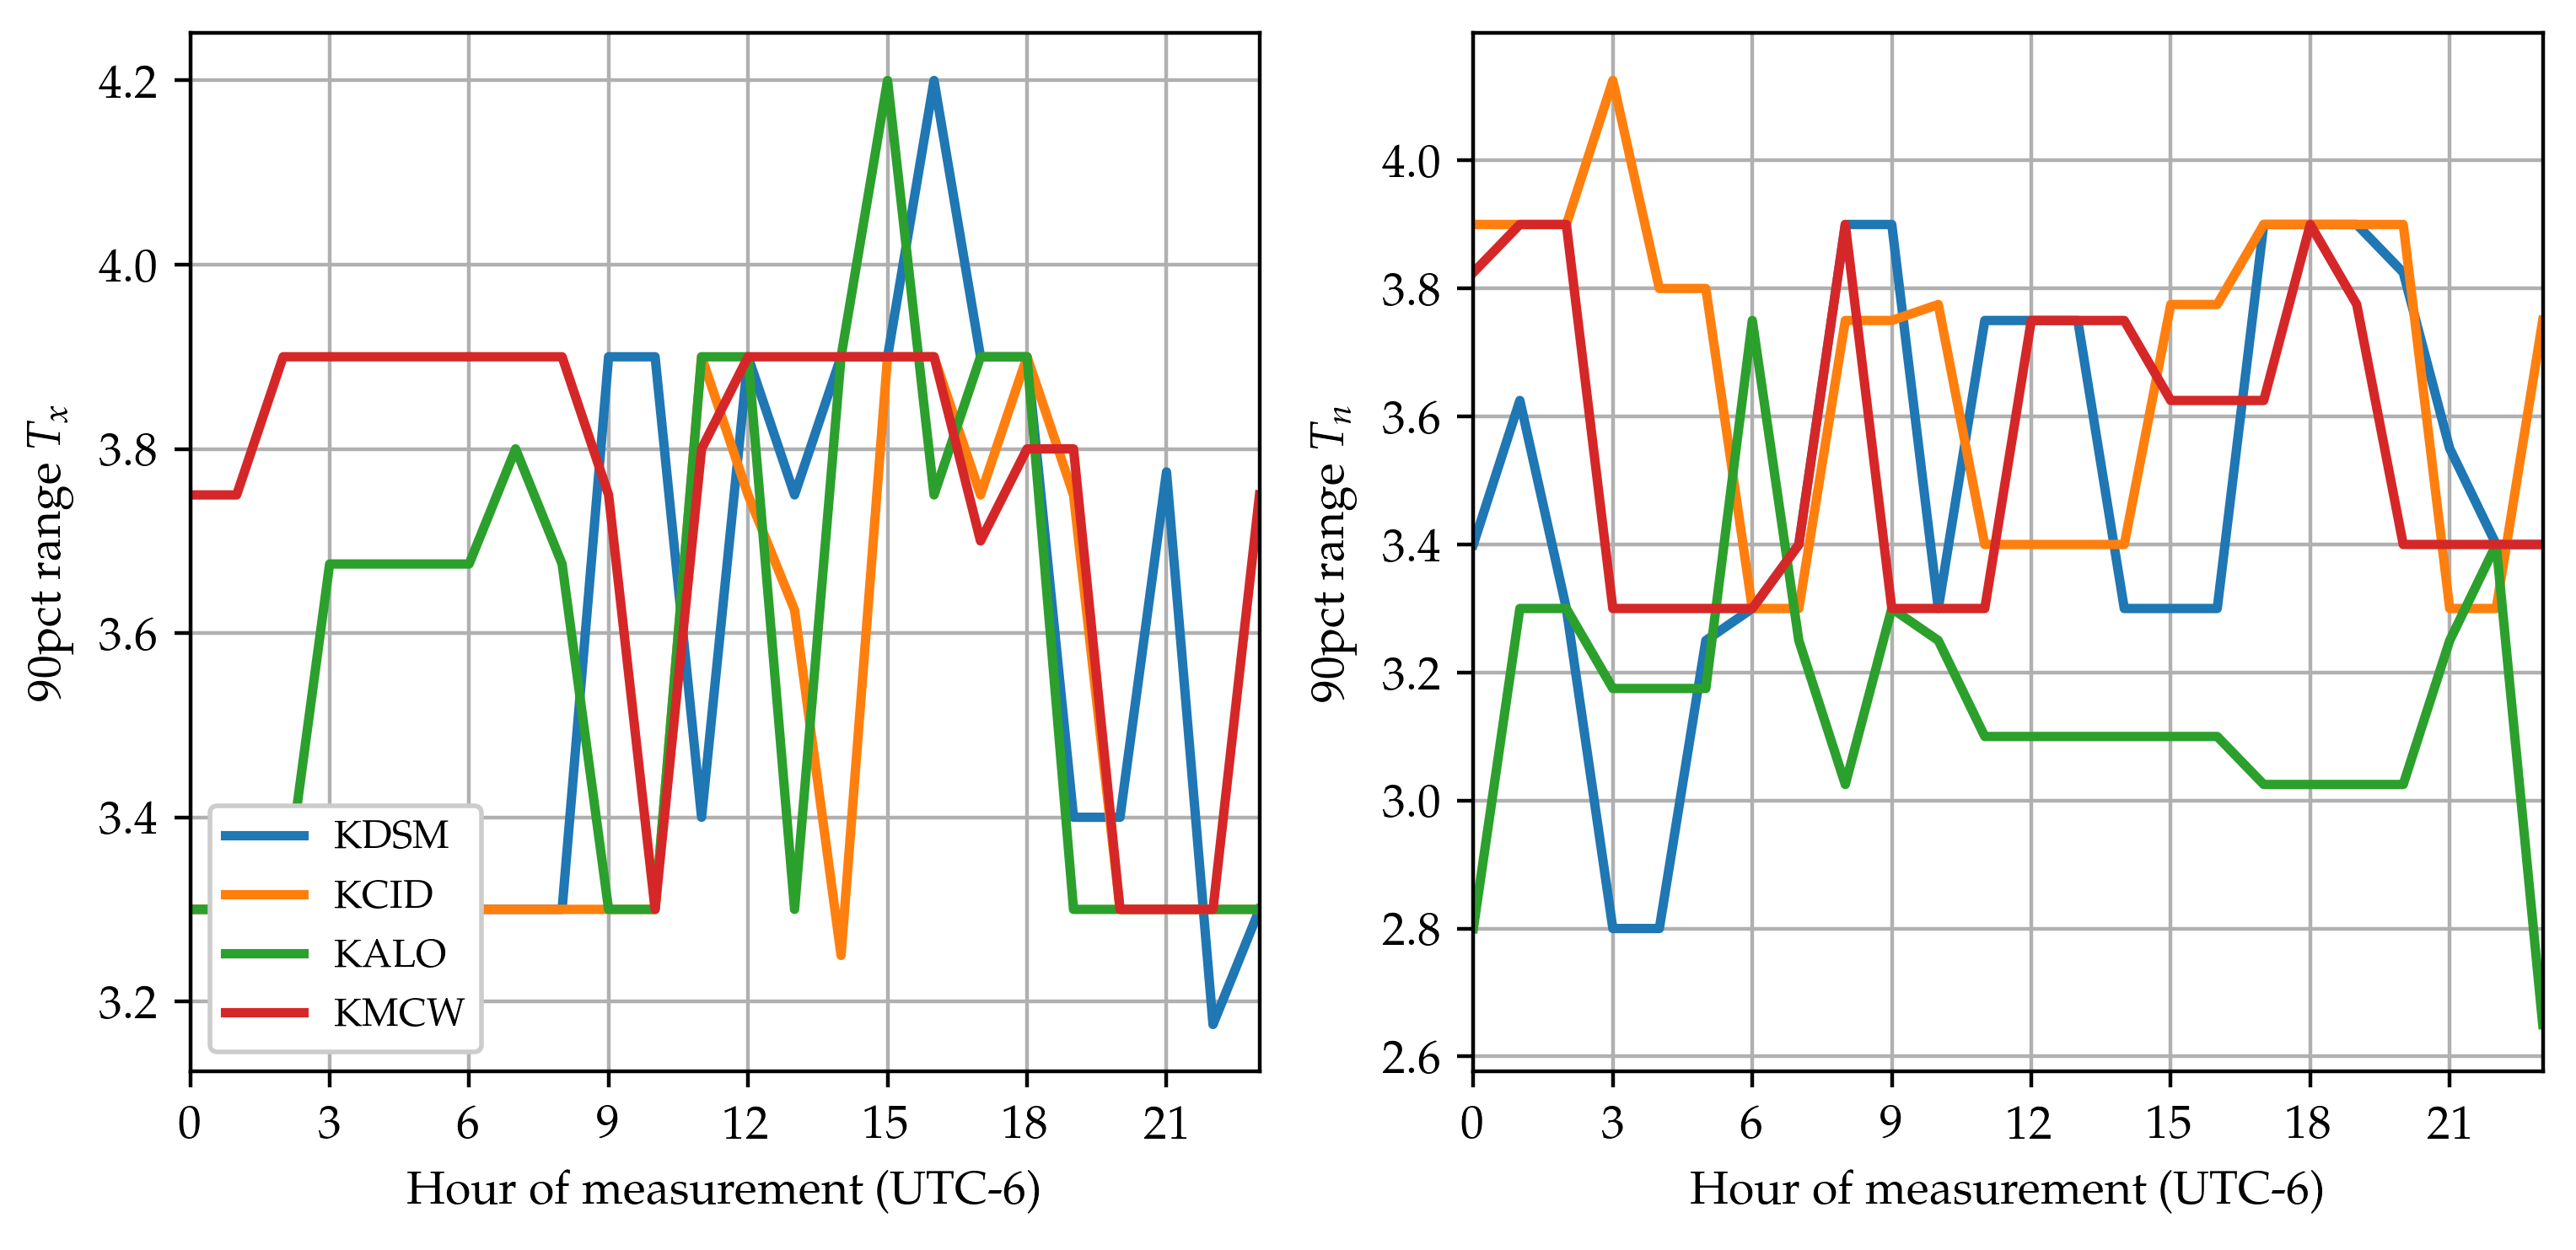

In [13]:
quantile_plot(90)
plt.gcf()[:set_size_inches](9.0, 4.0)
plt.savefig("../figures/waterloo_90range.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_90range.pdf", bbox_inches="tight")

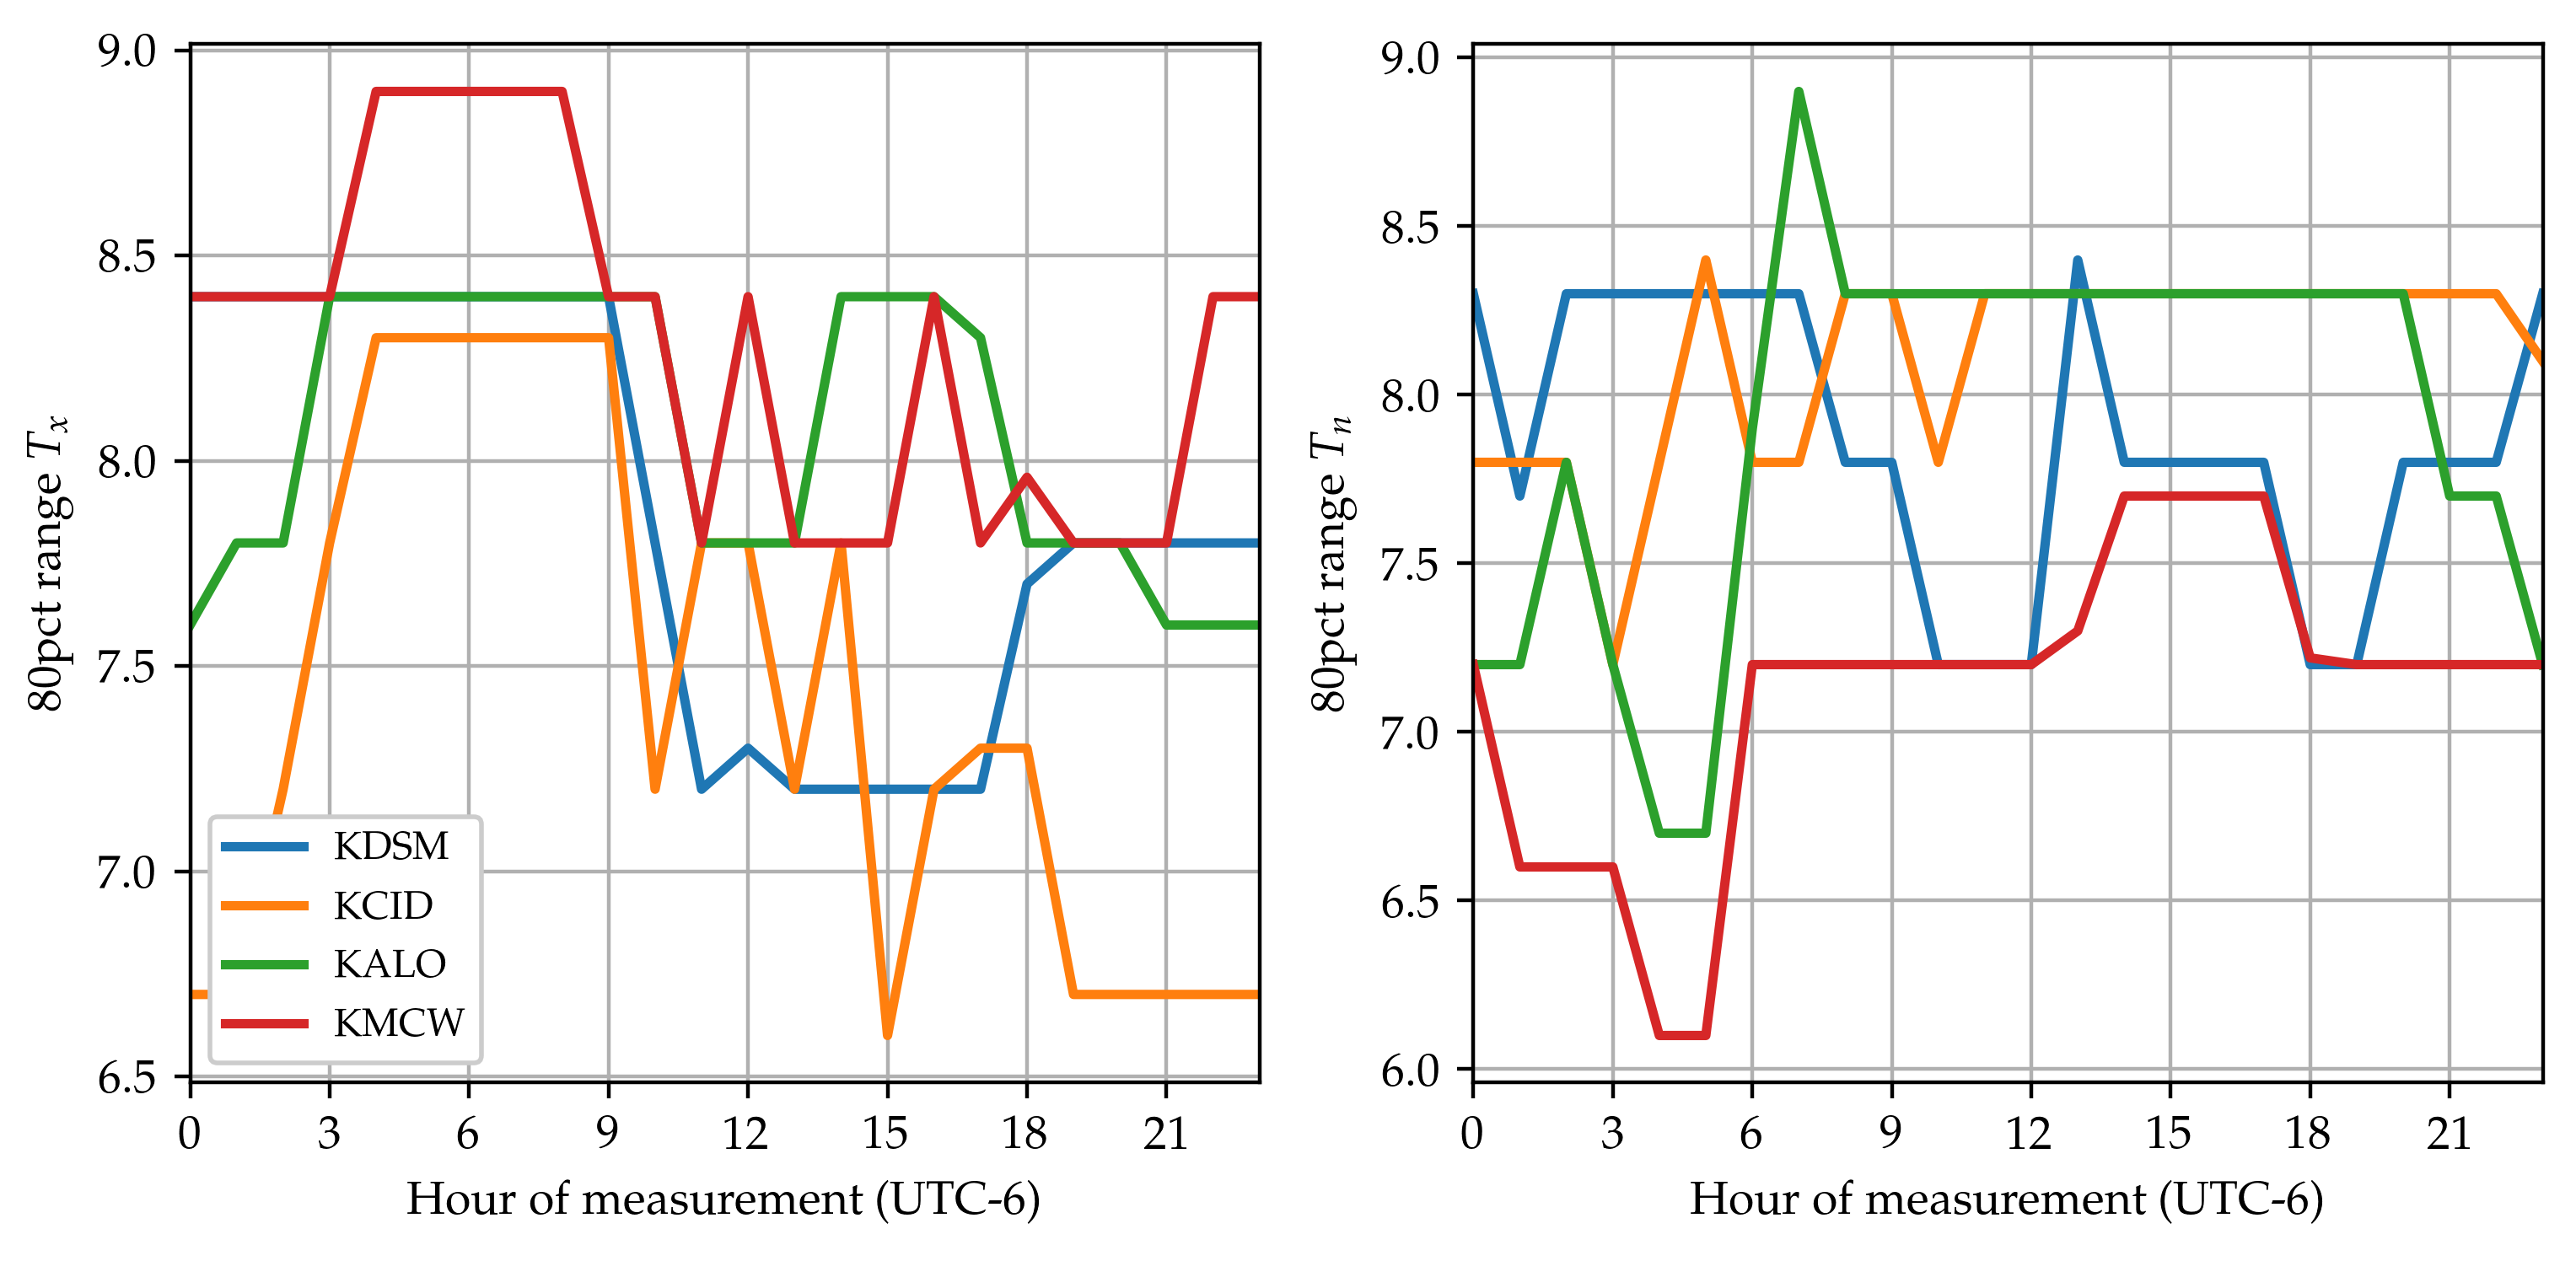

In [14]:
quantile_plot(80)
plt.gcf()[:set_size_inches](9.0, 4.0)
plt.savefig("../figures/waterloo_80range.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_80range.pdf", bbox_inches="tight")